In [1]:
import pandas as pd
import regex as re
import msoffcrypto
import openpyxl
from io import BytesIO
#pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import  shapiro
import scipy.stats as st
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error


## Loading the data

In [2]:
#Load all the data into dataframes from our documents
censo = pd.read_csv(r"Comercial_Censo.csv",sep=";", encoding='latin1')
meteo=pd.read_csv(r"Comercial_Meteorología.csv")
com_test=pd.read_csv(r"Comercial_Test.csv",sep=";", encoding='latin1')
ventas=pd.read_csv(r"Comercial_Ventas.csv",sep=";", encoding='latin1')

#The excel document is encrypted, we need to decrypt it
file_path = r"Comercial_ParqueVehiculos1.xlsx"
password = "IndesIA2022!"

with open(file_path, 'rb') as file:
    encrypted_file = msoffcrypto.OfficeFile(file)
    encrypted_file.load_key(password=password)
    
    decrypted_file = BytesIO()
    encrypted_file.decrypt(decrypted_file)
    decrypted_file.seek(0)

    #We load the data from the excel file differenciating the years
    parque2016 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=0, header=2)
    parque2017 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=1, header=2)
    parque2018 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=2, header=2)


## Cleaning Censo Dataset

In [3]:
def clean_name(text):
    return re.sub(r'^\d+\s*', '', text).strip()
censo['Municipio'] = censo['Municipio'].apply(clean_name)

dfs = []

#Lets transform the dataframe to handle easier the data
for year in censo.columns[1:]:
    temp_df = censo[['Municipio', year]].copy()
    temp_df.columns = ['Municipio', 'Total_Poblacion']
    temp_df['Año'] = year
    dfs.append(temp_df)

df_concatenated = pd.concat(dfs, ignore_index=True)
censo=df_concatenated

## Cleaning the Meteo Dataset

In [4]:
#Dropping the unnamed columns
meteo=meteo.drop(columns=["Unnamed: 0"])

#Fixing the name of the populations
meteo=meteo.replace("A CORUA","Coruña, A")

#Dropping useless columns
meteo.drop(columns=["provincia","indicativo","nombre"],inplace=True)

#Transforming the date to datetime
meteo["fecha"]=pd.to_datetime(meteo["fecha"])

#Creating new date columns
meteo['Year'] = pd.DatetimeIndex(meteo['fecha']).year
meteo['Month'] = pd.DatetimeIndex(meteo['fecha']).month 
meteo['Day'] = pd.DatetimeIndex(meteo['fecha']).day 
meteo['Weekday'] = pd.DatetimeIndex(meteo['fecha']).weekday

#Checking null values
meteo.isna().sum()
meteo.loc[meteo.isna().any(axis=1)]
meteo=meteo.dropna()

#Setting the date column as the index
#meteo.set_index("fecha",inplace=True)

## Cleaning Test Dataset

In [5]:
# Dropping the Unnamed column
com_test=com_test.drop(columns=["Unnamed: 0"])

# Converting the Dia column to datetime
com_test["Dia"] = pd.to_datetime(com_test["Dia"])

#Creating new date columns
com_test['Year'] = pd.DatetimeIndex(com_test['Dia']).year
com_test['Month'] = pd.DatetimeIndex(com_test['Dia']).month 
com_test['Day'] = pd.DatetimeIndex(com_test['Dia']).day 
com_test['Weekday'] = pd.DatetimeIndex(com_test['Dia']).weekday

#Importing a new dataset with the holidays in Spain in 2019 from the Spain Goverment website
file_path = 'Festivos_España_2019.csv'
fiestas2019 = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure and transforming the data
fiestas2019.head()
fiestas2019['Año'] = 2019
fiestas2019.drop(columns="Descripcion",inplace=True)

# Creating a mapping dictionary for the months to a better performance
month_mapping = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Apply the mapping to the "Mes" column
fiestas2019['Mes'] = fiestas2019['Mes'].map(month_mapping)

# Create a new 'Fecha' column by combining 'Mes', 'Dia', and 'Año'
fiestas2019['Fecha'] = pd.to_datetime(fiestas2019['Dia'].astype(str) + '-' + fiestas2019['Mes'].astype(str) + '-' + fiestas2019['Año'].astype(str), format='%d-%m-%Y')

# Drop the redundant columns
fiestas2019.drop(columns=['Mes', 'Dia', 'Año'], inplace=True)

#Adding a new column on the DataFrame
com_test['Fiesta'] = com_test['Dia'].isin(fiestas2019['Fecha']).astype(int)

#setting the index to the date
#com_test.set_index("Dia",inplace=True)

## Cleaning Ventas Dataset

In [6]:
#Dummifying the column Fiesta
ventas["Fiesta"]= ventas["Fiesta"].apply(lambda x: 1 if pd.notna(x) else 0)

#Creating date columns
ventas['Year'] = pd.DatetimeIndex(ventas['Dia']).year
ventas['Month'] = pd.DatetimeIndex(ventas['Dia']).month 
ventas['Day'] = pd.DatetimeIndex(ventas['Dia']).day 
ventas['Weekday'] = pd.DatetimeIndex(ventas['Dia']).weekday

#Lets check the missing values in the ventas dataset
ventas.info()
ventas.loc[ventas.isna().any(axis=1)]

#We take a look on the column PVP to analyze the possible cause od the missing values. Seeing that is a small amount of data we can drop it
pvpnan=ventas.loc[ventas["PVP"].isna()==True]

ventas=ventas.dropna()

#Setting the index to the date
ventas["Dia"] = pd.to_datetime(ventas["Dia"], format='%d/%m/%Y')
#ventas.set_index("Dia",inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Dia       26304 non-null  object
 1   Producto  26304 non-null  object
 2   Latitud   26303 non-null  object
 3   Longitud  26303 non-null  object
 4   PVP       25080 non-null  object
 5   VentasN   26288 non-null  object
 6   Nombre    26304 non-null  object
 7   Day       26304 non-null  int32 
 8   Month     26304 non-null  int32 
 9   Year      26304 non-null  int32 
 10  Weekday   26304 non-null  int32 
 11  Fiesta    26304 non-null  int64 
dtypes: int32(4), int64(1), object(7)
memory usage: 2.0+ MB


## Cleaning Parque Dataset

In [7]:
parque2016.columns=parque2016.columns.str.replace("\n"," ")
parque2017.columns=parque2017.columns.str.replace("\n"," ")
parque2018.columns=parque2018.columns.str.replace("\n"," ")

#Lets clean thhe parques dataset
parque2016=parque2016.drop(columns=["PROVINCIAS"])
parque2017=parque2017.drop(columns=["PROVINCIAS"])
parque2018=parque2018.drop(columns=["PROVINCIAS"])

#We rename the columns to avoid confusion when merging the dataframes 
parque2016=parque2016.add_suffix("_2016")
parque2017=parque2017.add_suffix("_2017")
parque2018=parque2018.add_suffix("_2018")

#This dataset has the Camiones and furgonetas merged, while the others it has them separated. We will merge them in the other datasets due we dont have the data about the individual types of vehicles
parque2016.columns

parque2017["CAMIONES y FURGONETAS_2017"]=parque2017["CAMIONES_2017"]+parque2017["FURGONETAS_2017"]
parque2017=parque2017.drop(columns=["CAMIONES_2017","FURGONETAS_2017"])

parque2018["CAMIONES y FURGONETAS_2018"]=parque2018["CAMIONES_2018"]+parque2018["FURGONETAS_2018"]
parque2018=parque2018.drop(columns=["CAMIONES_2018","FURGONETAS_2018"])

#Rename the columns to merge the datasets
parque2016 = parque2016.rename(columns={"MUNICIPIOS_2016": "MUNICIPIOS"})
parque2017 = parque2017.rename(columns={"MUNICIPIOS_2017": "MUNICIPIOS"})
parque2018 = parque2018.rename(columns={"MUNICIPIOS_2018": "MUNICIPIOS"})

#Lets create a single dataset with the data from the 3 years
parque_m=pd.merge(parque2016,parque2017,how="inner",on="MUNICIPIOS")
parque=pd.merge(parque_m,parque2018,how="inner",on="MUNICIPIOS")

parque.columns=parque.columns.str.capitalize()

years = ['2016', '2017', '2018']

long_format = []
for index, row in parque.iterrows():
    for year in years:
        long_format.append({
            'Municipios': row['Municipios'],
            'year': year,
            'Camiones y furgonetas': row[f'Camiones y furgonetas_{year}'],
            'Autobuses': row[f'Autobuses_{year}'],
            'Turismos': row[f'Turismos_{year}'],
            'Motocicletas': row[f'Motocicletas_{year}'],
            'Tractores industriales': row[f'Tractores industriales_{year}'],
            'Remolques y semirremolques': row[f'Remolques y semirremolques_{year}'],
            'Otros vehículos': row[f'Otros vehículos_{year}'],
            'Total': row[f'Total_{year}'],
        })

parque = pd.DataFrame(long_format)

parque.head()

parque.duplicated().sum()

parque.nunique()

for col in parque.columns:
    print(parque[col].unique())

parque.isnull().sum()

#Lets change this value to avoid confusion
result = parque[parque['Municipios'] == 'Coruña (A) ( municipio sin especificar)']
parque=parque.replace("Coruña (A) ( municipio sin especificar)","Otro")

['Abegondo' 'Ames' 'Aranga' 'Ares' 'Arteixo' 'Arzúa' 'Baña, A' 'Bergondo'
 'Betanzos' 'Boimorto' 'Boiro' 'Boqueixón' 'Brión' 'Cabana de Bergantiños'
 'Cabanas' 'Camariñas' 'Cambre' 'Capela, A' 'Carballo' 'Cariño' 'Carnota'
 'Carral' 'Cedeira' 'Cee' 'Cerceda' 'Cerdido' 'Coirós' 'Corcubión'
 'Coristanco' 'Coruña (A) ( municipio sin especificar)' 'Coruña, A'
 'Culleredo' 'Curtis' 'Dodro' 'Dumbría' 'Fene' 'Ferrol' 'Fisterra'
 'Frades' 'Irixoa' 'Laracha, A' 'Laxe' 'Lousame' 'Malpica de Bergantiños'
 'Mazaricos' 'Mañón' 'Melide' 'Mesía' 'Miño' 'Moeche' 'Monfero' 'Mugardos'
 'Muros' 'Muxía' 'Narón' 'Neda' 'Negreira' 'Noia' 'Oleiros' 'Ordes'
 'Oroso' 'Ortigueira' 'Outes' 'Oza-Cesuras' 'Paderne' 'Padrón' 'Pino, O'
 'Pobra do Caramiñal, A' 'Ponteceso' 'Pontedeume'
 'Pontes de García Rodríguez, As' 'Porto do Son' 'Rianxo' 'Ribeira' 'Rois'
 'Sada' 'San Sadurniño' 'Santa Comba' 'Santiago de Compostela' 'Santiso'
 'Sobrado' 'Somozas, As' 'Teo' 'Toques' 'Tordoia' 'Touro' 'Trazo'
 'Val do Dubra' 'Vald

## Creating a Station Dataset

In [8]:
stations=ventas.drop(columns=['Producto','PVP', 'VentasN','Day','Month', 'Year', 'Weekday', 'Fiesta'])
stations.drop_duplicates(inplace=True)
stations.reset_index(inplace=True)
stations=stations.drop(columns=["Dia"])
stations=stations.dropna()

# We check if there is another duplicates in the data by checking the coordinates
stations["Longitud"].duplicated()
stations.drop_duplicates(subset=["Latitud","Longitud"],inplace=True)

#Setting the index to the name of the station
stations=stations.set_index("Nombre").sort_index()

#I think we should take out the coordinates out of the datasets, the value of the information is "included" on the Station itself

import requests

# Convert the 'Latitud' and 'Longitud' columns to string type if they are not already
stations['Latitud'] = stations['Latitud'].astype(str)
stations['Longitud'] = stations['Longitud'].astype(str)

# Replacing dots for commas
stations["Latitud"] = stations["Latitud"].str.replace(",", ".").astype(float)
stations["Longitud"] = stations["Longitud"].str.replace(",", ".").astype(float)

# define a function to get municipality using Nominatim
def get_municipality(lat, lon):
    try:
        url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json&accept-language=en&addressdetails=1"
        response = requests.get(url, verify=False)  # Bypass SSL certificate verification
        if response.status_code == 200:
            data = response.json()
            if 'address' in data and 'city' in data['address']:
                return data['address']['city']
            elif 'address' in data and 'town' in data['address']:
                return data['address']['town']
            elif 'address' in data and 'village' in data['address']:
                return data['address']['village']
            elif 'address' in data and 'county' in data['address']:
                return data['address']['county']
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

stations["Municipio"] = stations.apply(lambda x: get_municipality(x["Latitud"], x["Longitud"]), axis=1)


## Merging Datasets

### Concatenating ventas and test

In [9]:
df_ventas_test = pd.concat([com_test, ventas], axis=0)
df_ventas_test=df_ventas_test.sort_values(by="Dia")

### Merging with meteo

In [10]:
df_ventas_test_meteo = pd.merge(df_ventas_test, meteo, how="inner", left_on=["Dia"], right_on=["fecha"])
df_ventas_test_meteo.drop(columns=["Year_x","Month_x","Day_x","Weekday_x"],inplace=True)

### Merging with Stations

In [11]:
df_ventas_test_meteo_st= pd.merge(df_ventas_test_meteo, stations, how="left", on="Nombre")
df_ventas_test_meteo_st.drop(columns=["index","Latitud_y","Longitud_y"],inplace=True)
df_ventas_test_meteo_st['Year_y'] = df_ventas_test_meteo_st['Year_y'].astype(str)

### Merging with Censo

In [12]:
df_ventas_test_meteo_st_censo = df_ventas_test_meteo_st.merge(censo, how='left', left_on=['Municipio', 'Year_y'], right_on=['Municipio', 'Año'])

### Merging with the Parque data

In [13]:
df_ventas_test_meteo_st_censo_parque = df_ventas_test_meteo_st_censo.merge(parque, how='left', left_on=['Municipio', 'Year_y'], right_on=['Municipios', 'year'])

df_ventas_test_meteo_st_censo_parque.drop(columns=["Municipios","year",'Month_y', 'Day_y', 'Weekday_y','Year_y',"Año"], inplace=True)
df_ventas_test_meteo_st_censo_parque.rename(columns={"Latitud_x":"Latitud","Longitud_x": "Longitud"},inplace=True)


### Apply some transformations to data

In [15]:
# Transform the 'VentasN' column to float
df_ventas_test_meteo_st_censo_parque['VentasN'] = df_ventas_test_meteo_st_censo_parque['VentasN'].str.replace(',', '.').astype(float)

In [16]:
# Create the IQR
Q1 = df_ventas_test_meteo_st_censo_parque['VentasN'].quantile(0.25)
Q3 = df_ventas_test_meteo_st_censo_parque['VentasN'].quantile(0.75)
IQR = Q3 - Q1
# Create a list with the outliers
outliers = df_ventas_test_meteo_st_censo_parque['VentasN'][(df_ventas_test_meteo_st_censo_parque['VentasN'] < (Q1 - 1.5 * IQR)) | (df_ventas_test_meteo_st_censo_parque['VentasN'] > (Q3 + 1.5 * IQR))]

# To check in which rows the outliers are
#outliers

# Define the upper bound for outliers
upper_bound = Q3 + 1.5 * IQR
upper_bound=1.15

# Upper bound is 1.18 and we have one outiler of 1.16. We will replace it with the maximum value within the IQR because if not, we still get an outlier on the product 95

# Get the maximum value within the IQR
max_iqr_value = df_ventas_test_meteo_st_censo_parque["VentasN"][(df_ventas_test_meteo_st_censo_parque["VentasN"] >= Q1) & (df_ventas_test_meteo_st_censo_parque["VentasN"] <= Q3)].max()

# Copy the dataframe and replace outliers in 'VentasN' with the max_iqr_value
data_no_outliers = df_ventas_test_meteo_st_censo_parque.copy()
data_no_outliers['VentasN'] = data_no_outliers['VentasN'].apply(lambda x: max_iqr_value if x > upper_bound else x)

# Check the rows with the outliers to see if they were replaced
#data_no_outliers.iloc[21777,:]
#df_ventas_test_meteo_st_censo_parque.iloc[[20963,21777],:]

In [18]:
# Separate the data into two dataframes: one for each product and extract a csv of them
df = data_no_outliers.copy()

prod_95= df[df["Producto"]=="95"]
goa= df[df["Producto"]=="GOA"]

prod_95[['Dia','VentasN']].to_csv('ar_95.csv', index=False)
goa[['Dia','VentasN']].to_csv('ar_goa.csv', index=False)

### ARIMA model

#### Lets start for the Gasoleo A product

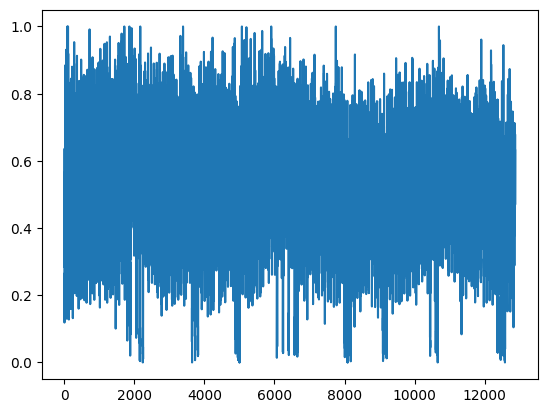

In [19]:
data = pd.read_csv('ar_goa.csv')
data.dtypes
y = data.iloc[:,1]
y.plot()
plt.show()

train_size = int(len(y) * 0.8) 
train, test = y[:train_size], y[train_size:]

#we should remove the outlier(for this i tried with the outlier removed)

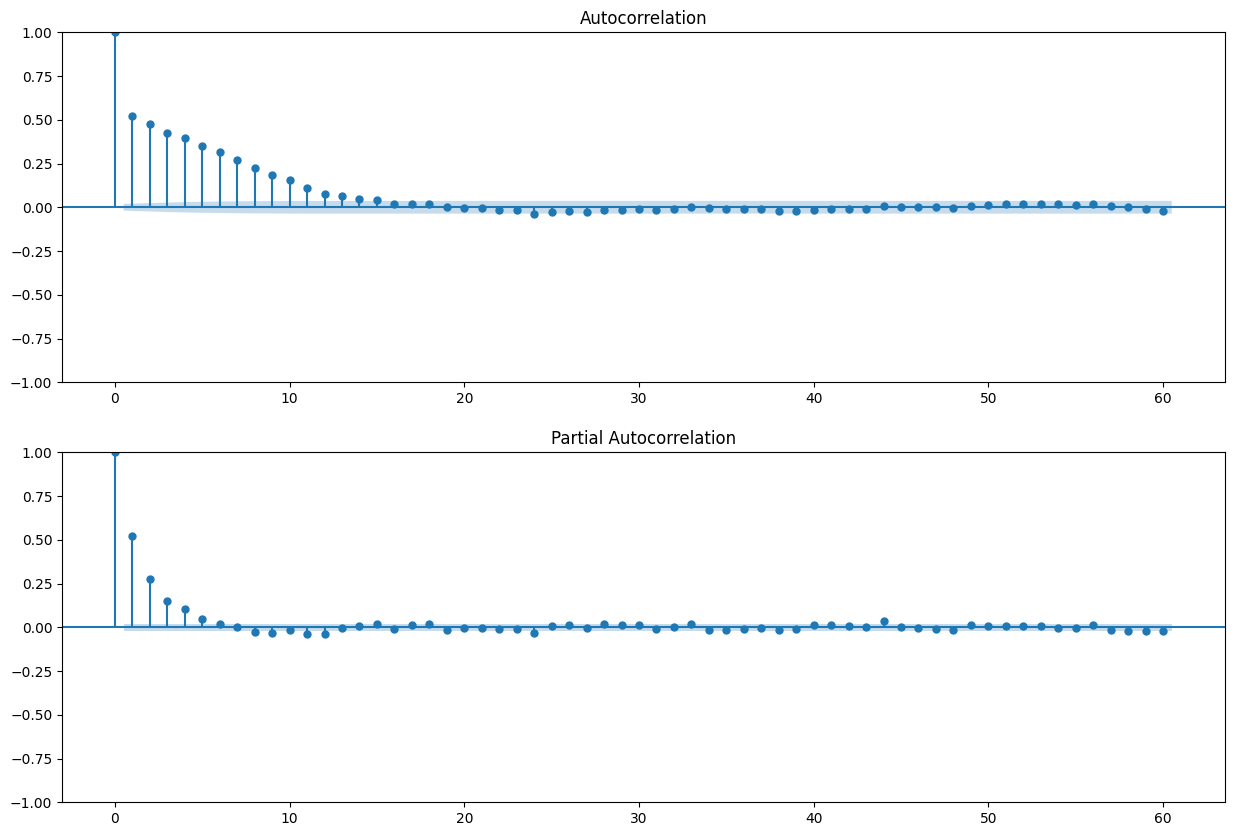

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 60 # play with this parameter

fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(train, lags = nlags,  ax=ax[0])
plot_pacf(train, lags = nlags, method="ols",ax=ax[1])
plt.show()

In [21]:
s = 5 #seasonal parameter
import statsmodels.api as sm
from pmdarima.arima import ndiffs, nsdiffs

# Coincide con lo de R
print('Regular difference:', ndiffs(train, alpha = 0.05, test = 'adf'))
print('Seasonal difference:', nsdiffs(train, m = s, test = 'ocsb'))

Regular difference: 0
Seasonal difference: 0


In [22]:
box_test = sm.stats.acorr_ljungbox(train, lags=[50])
print("Box test for r:", box_test.iloc[0,0]) # Se parece a lo de R pero varía un poco
print("p-value:", box_test.iloc[0,1]) # Casi igual que en R

Box test for r: 13145.255812380976
p-value: 0.0


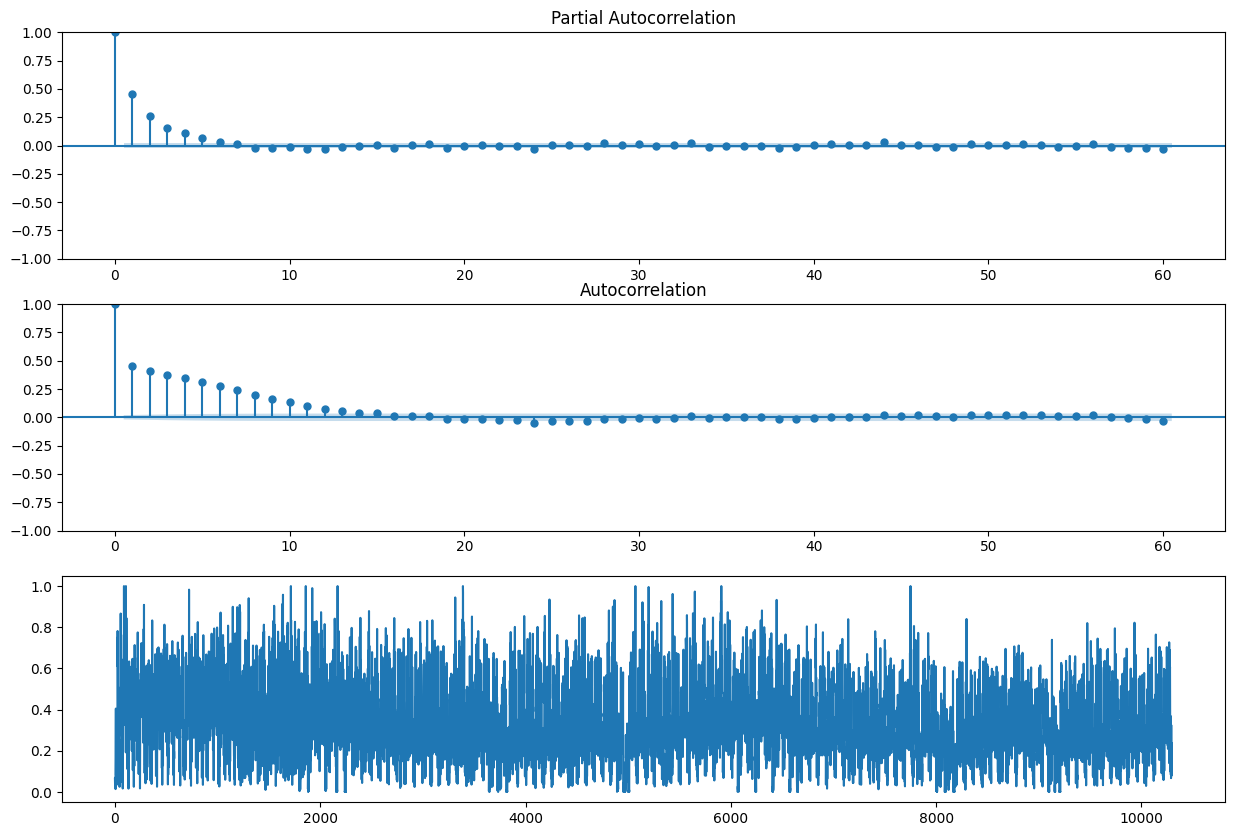

In [23]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(train**2, lags = nlags, method="ols", ax=ax[0])
plot_acf(train**2, lags = nlags, ax=ax[1])
ax[2] = plt.plot(train**2)
plt.show()

In [24]:
fit = sm.tsa.arima.ARIMA(train, order = (4,0,4)).fit(method = 'innovations_mle')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                VentasN   No. Observations:                10296
Model:                 ARIMA(4, 0, 4)   Log Likelihood                5898.315
Date:                Tue, 11 Jun 2024   AIC                         -11776.631
Time:                        00:09:37   BIC                         -11704.236
Sample:                             0   HQIC                        -11752.161
                              - 10296                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5594      0.005    104.444      0.000       0.549       0.570
ar.L1          1.8953      0.433      4.382      0.000       1.048       2.743
ar.L2         -0.7491      1.099     -0.682      0.495      -2.903       1.405
ar.L3         -0.6591      1.015     -0.649      0.516      -2.648       1.330
ar.L4          0.4656      0.337      1.382      0.167      -0.195       1.126
ma.L1         -1.5851      0.434     -3.649      0.000      -2.436      -0.734
ma.L2          0.4478      0.970      0.461      0.644      -1.454       2.350
ma.L3          0.6006      0.800      0.751      0.453      -0.967       2.168
ma.L4         -0.2775      0.218     -1.273      0.203      -0.705       0.150
sigma2         0.0186      0.000     75.271      0.000       0.018       0.019
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               167.29
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

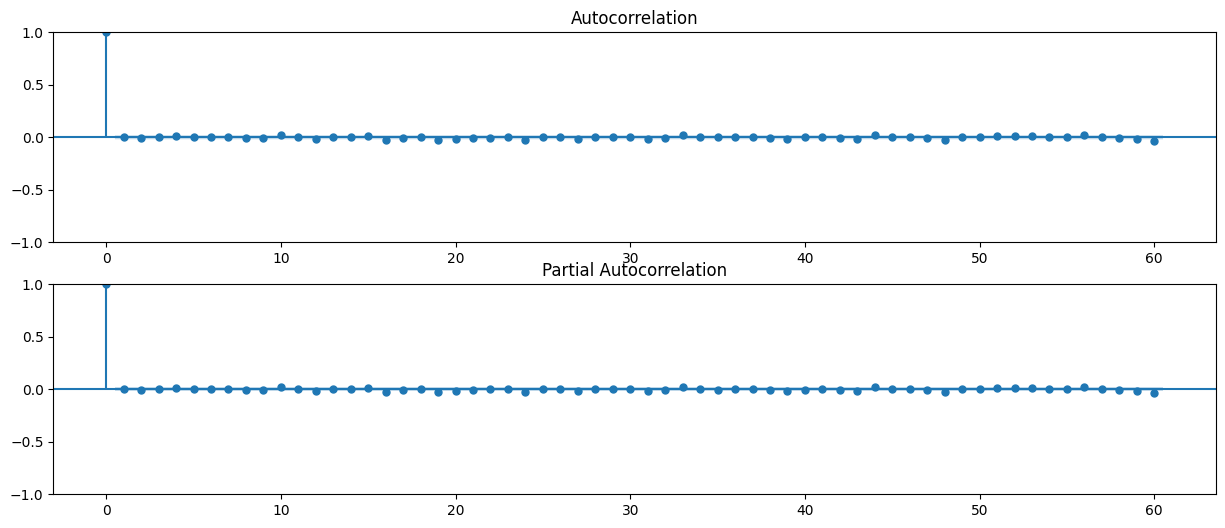

In [25]:
fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(fit.resid, lags = nlags, ax=ax[0])
plot_pacf(fit.resid, lags = nlags, method="ols", ax=ax[1])
plt.show()

In [26]:
print("Shapiro test:",shapiro(fit.resid)[0])
print("Shapiro p-value:",shapiro(fit.resid)[1])

Shapiro test: 0.9955900311470032
Shapiro p-value: 3.603143161743825e-17


(-0.6822295686955434, 0.6823444467398468)

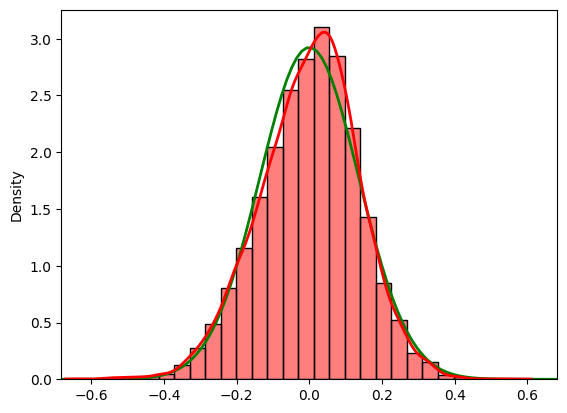

In [27]:
mu = np.mean(fit.resid)
sigma = np.std(fit.resid)
x = np.linspace(mu -5*sigma, mu + 5*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = sns.histplot(fit.resid, stat="density", color = "red",
                  kde = True, line_kws={'lw': 2}, bins = 30
                   ) # NEW

# ax = plt.hist(fit.resid, density = True, range = (mu -4*sigma, mu + 4*sigma), color = "fit.resid")
# ax = sns.distplot(fit.resid, hist = False, kde = True, kde_kws = {'linewidth':2},
#                  color = "blue") # OLD-DEPRECATD
ax.set_xlim(mu -5*sigma, mu + 5*sigma)

In [28]:
predictions = fit.forecast(steps = len(test))

In [29]:
mse = mean_squared_error(test, predictions)
print("Mean squared error : " , mse)

mae = mean_absolute_error(test, predictions)
print('Mean Absolute Error (MAE):', mae)

mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

mrse = np.sqrt(mean_squared_error(test, predictions))
rmse= np.sqrt(mrse)
print('Root Mean Squared Error (RMSE):', rmse)


Mean squared error :  0.026568871060120413
Mean Absolute Error (MAE): 0.1268121793276363
Mean Absolute Percentage Error (MAPE): inf
Root Mean Squared Error (RMSE): 0.40373209493229184


#### Lets do it now for the 95

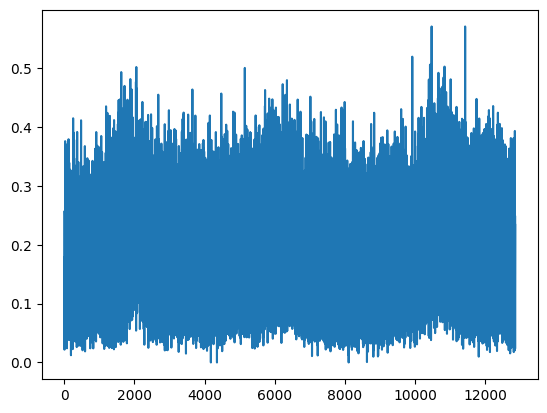

In [32]:
data = pd.read_csv('ar_95.csv')
y = data.iloc[:,1]
y.plot()
plt.show()

train_size = int(len(y) * 0.8) 
train, test = y[:train_size], y[train_size:]

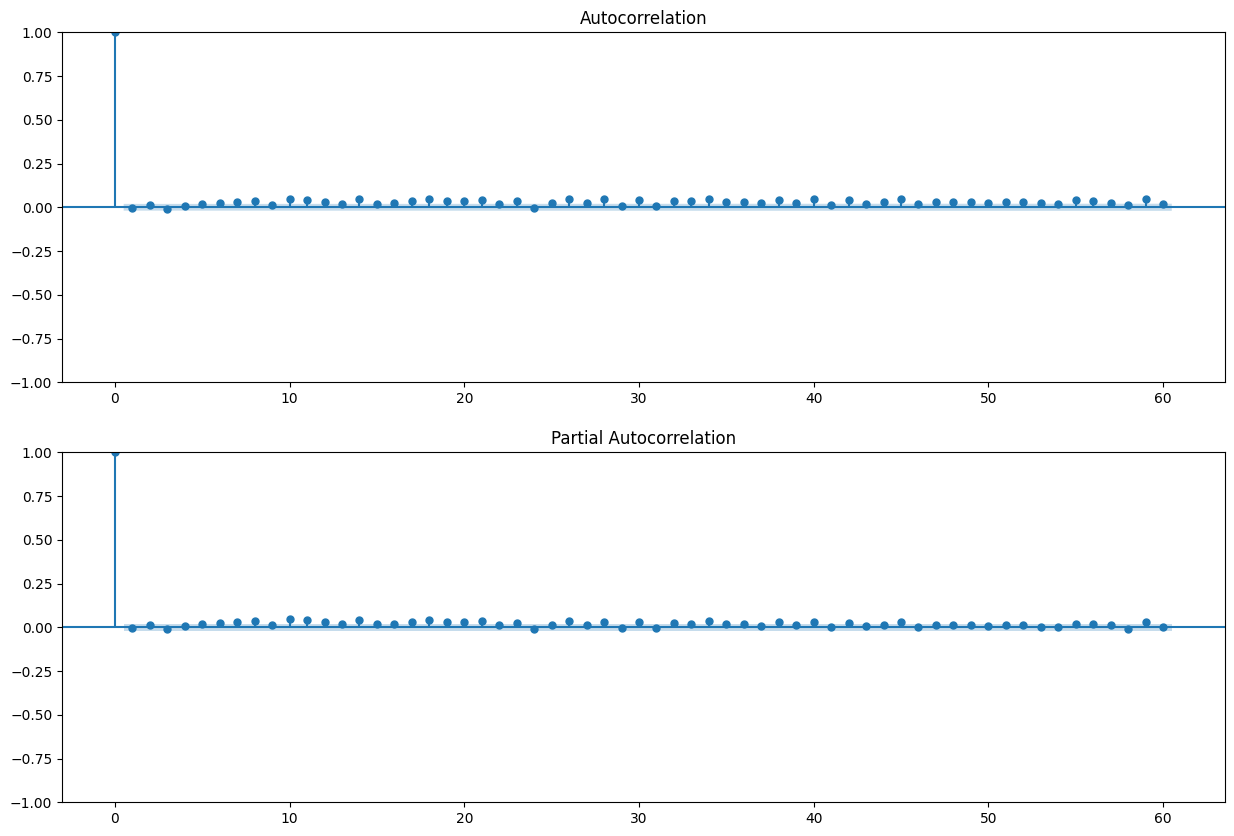

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 60 # play with this parameter

fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(train, lags = nlags,  ax=ax[0])
plot_pacf(train, lags = nlags, method="ols",ax=ax[1])
plt.show()

In [34]:
s = 5 #seasonal parameter
import statsmodels.api as sm
from pmdarima.arima import ndiffs, nsdiffs

# Coincide con lo de R
print('Regular difference:', ndiffs(train, alpha = 0.05, test = 'adf'))
print('Seasonal difference:', nsdiffs(train, m = s, test = 'ocsb'))

Regular difference: 0
Seasonal difference: 0


In [35]:
box_test = sm.stats.acorr_ljungbox(train, lags=[50])
print("Box test for r:", box_test.iloc[0,0]) # Se parece a lo de R pero varía un poco
print("p-value:", box_test.iloc[0,1]) # Casi igual que en R

Box test for r: 500.90238701251536
p-value: 1.1236337491900708e-75


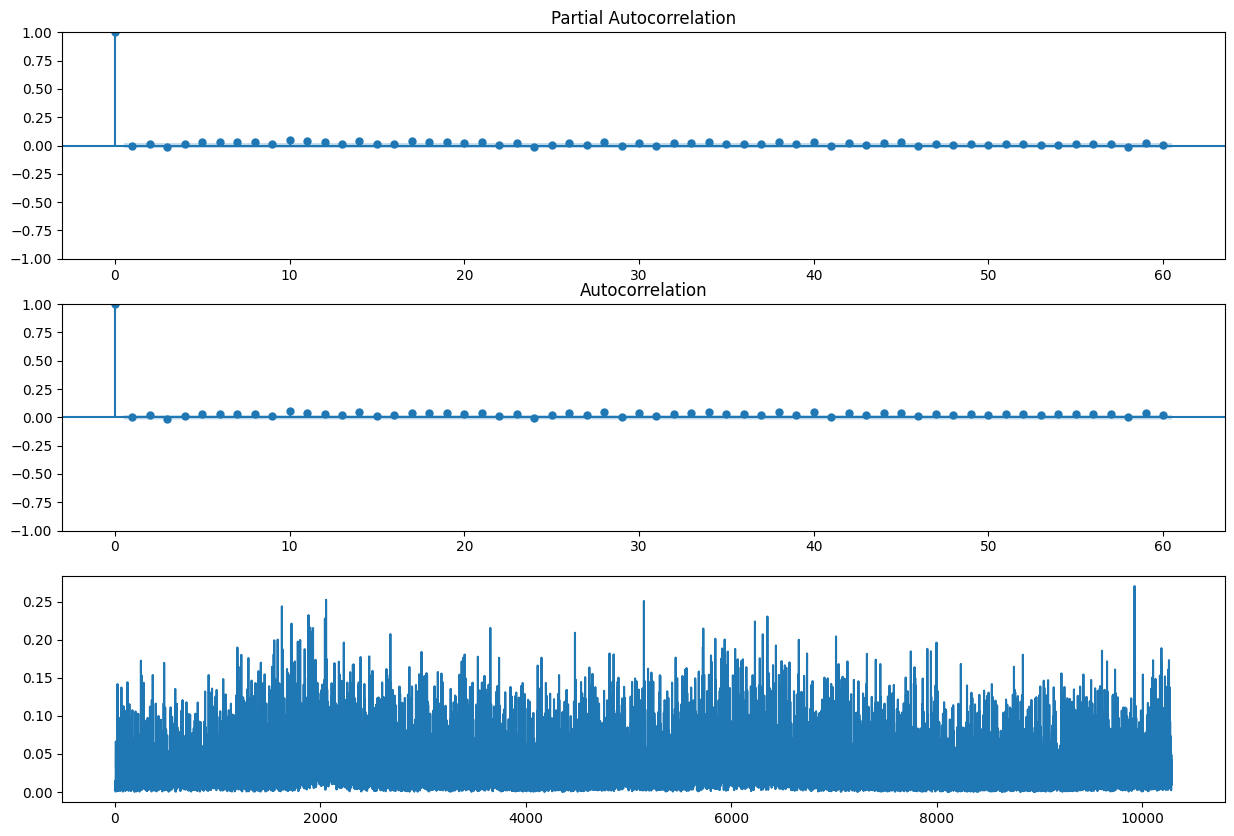

In [36]:
fig, ax = plt.subplots(3,1, figsize = (15,10))
plot_pacf(train**2, lags = nlags, method="ols", ax=ax[0])
plot_acf(train**2, lags = nlags, ax=ax[1])
ax[2] = plt.plot(train**2)
plt.show()

In [37]:
fit = sm.tsa.arima.ARIMA(train, order = (0,0,0)).fit(method = 'innovations_mle')
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                VentasN   No. Observations:                10288
Model:                          ARIMA   Log Likelihood                9807.911
Date:                Tue, 11 Jun 2024   AIC                         -19611.822
Time:                        00:09:40   BIC                         -19597.344
Sample:                             0   HQIC                        -19606.928
                              - 10288                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1753      0.001    173.921      0.000       0.173       0.177
sigma2         0.0087      0.000     58.613      0.000       0.008       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               529.25
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.52
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

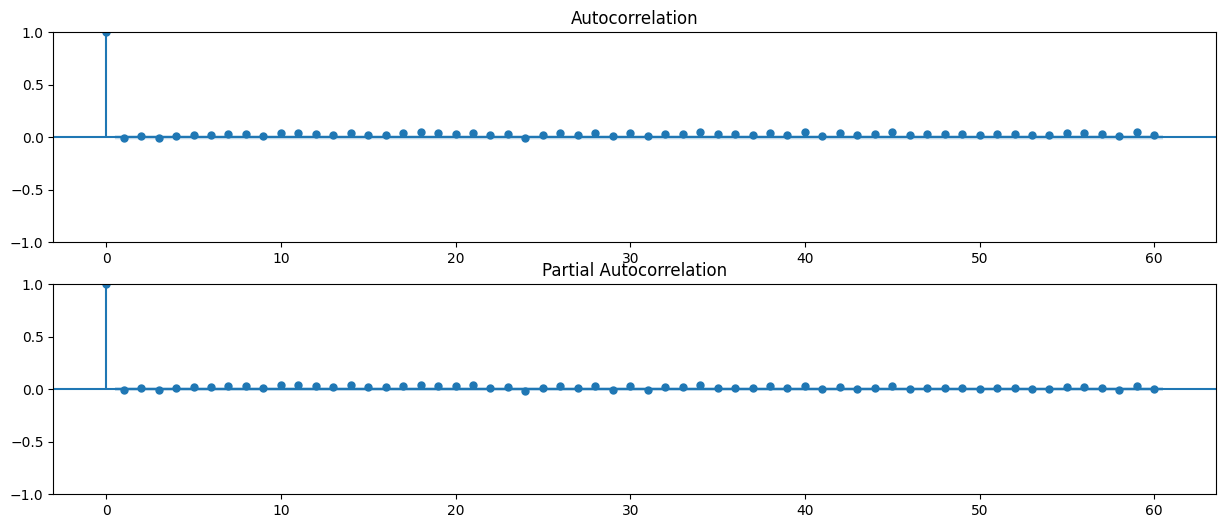

In [38]:
fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(fit.resid, lags = nlags, ax=ax[0])
plot_pacf(fit.resid, lags = nlags, method="ols", ax=ax[1])
plt.show()

In [39]:
print("Shapiro test:",shapiro(fit.resid)[0])
print("Shapiro p-value:",shapiro(fit.resid)[1])

Shapiro test: 0.9661783576011658
Shapiro p-value: 1.2751816025355835e-43


(-0.46634216280917506, 0.4663421628091752)

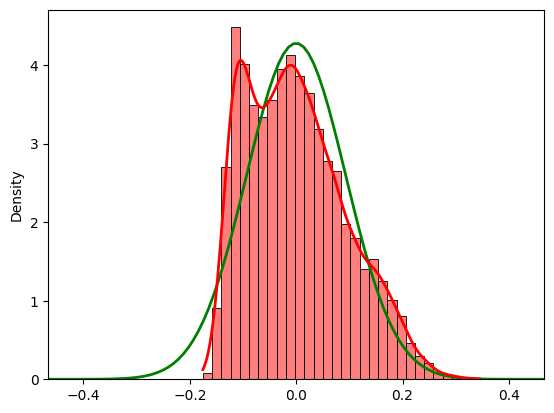

In [40]:
mu = np.mean(fit.resid)
sigma = np.std(fit.resid)
x = np.linspace(mu -5*sigma, mu + 5*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = sns.histplot(fit.resid, stat="density", color = "red",
                  kde = True, line_kws={'lw': 2}, bins = 30
                   ) # NEW

# ax = plt.hist(fit.resid, density = True, range = (mu -4*sigma, mu + 4*sigma), color = "fit.resid")
# ax = sns.distplot(fit.resid, hist = False, kde = True, kde_kws = {'linewidth':2},
#                  color = "blue") # OLD-DEPRECATD
ax.set_xlim(mu -5*sigma, mu + 5*sigma)

In [41]:
predictions = fit.forecast(steps = len(test))

In [42]:
mse = mean_squared_error(test, predictions)
print("Mean squared error : " , mse)

mae = mean_absolute_error(test, predictions)
print('Mean Absolute Error (MAE):', mae)

mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

mrse = np.sqrt(mean_squared_error(test, predictions))
rmse= np.sqrt(mrse)
print('Root Mean Squared Error (RMSE):', rmse)


Mean squared error :  0.009645436201910903
Mean Absolute Error (MAE): 0.07917071436151715
Mean Absolute Percentage Error (MAPE): 64.10892512003727
Root Mean Squared Error (RMSE): 0.31338663285817225
